# Project 3 — Predicting House Prices (Kaggle - House Prices: Advanced Regression Techniques)

This notebook contains: EDA, preprocessing, three regression experiments (baseline linear regression, improved preprocessing with linear model, and regularized/ensemble models), evaluation using RMSE, and instructions to generate a submission file for Kaggle or to run locally.

Files expected in the same folder:
- `train.csv` (training data)
- `test.csv` (test data without SalePrice)

## 0. Quick instructions (run locally)

1) Install required packages (create a venv or conda env).
2) Launch Jupyter or open this notebook in VS Code and run cells top-to-bottom.

Commands (PowerShell):
```powershell
pip install -r requirements.txt; jupyter notebook
```

If you don't have a `requirements.txt`, install: pandas, numpy, scikit-learn, seaborn, matplotlib, joblib.

In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)

In [14]:
# Utility: RMSE (for cross-val we use negative MSE returned by scikit-learn)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def cv_rmse(model, X, y, cv=5):
    # use neg_mean_squared_error, return RMSE mean
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()

In [15]:
# Load datasets (assumes train.csv and test.csv are in notebook folder)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('train shape:', train.shape)
print('test shape:', test.shape)
train.head()

train shape: (1460, 81)
test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1. Data understanding (Experiment 1 — EDA)

We examine target distribution, missing values, and correlations to choose initial features for a baseline model.

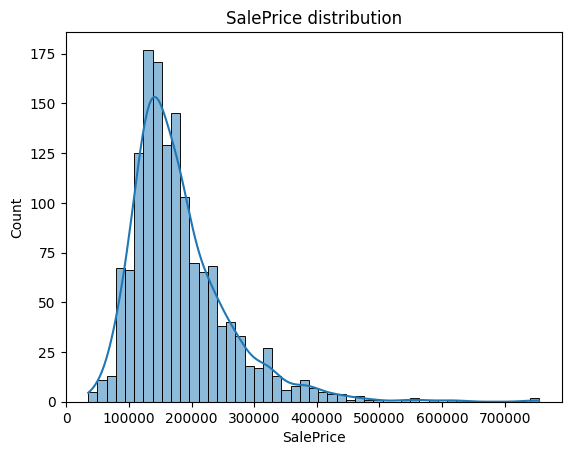

In [16]:
# Target distribution
sns.histplot(train['SalePrice'], kde=True);
plt.title('SalePrice distribution');

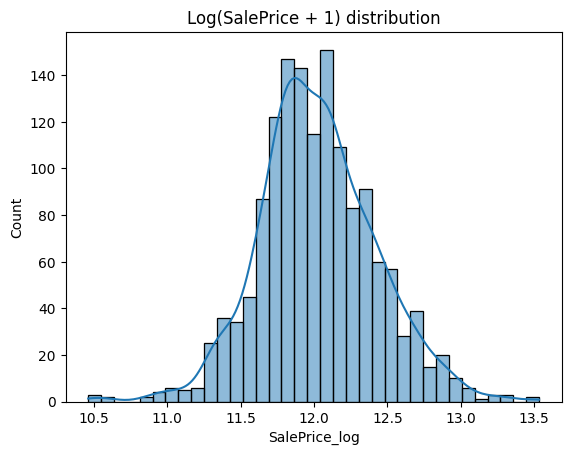

In [17]:
# Log-transform target for modeling stability (common for House Prices)
train['SalePrice_log'] = np.log1p(train['SalePrice'])
sns.histplot(train['SalePrice_log'], kde=True);
plt.title('Log(SalePrice + 1) distribution');

In [18]:
# Missing values overview (top 20)
na_counts = train.isnull().sum().sort_values(ascending=False)
na_counts[na_counts>0].head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageYrBlt       81
GarageFinish      81
GarageType        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtFinType1      37
BsmtCond          37
MasVnrArea         8
Electrical         1
dtype: int64

In [19]:
# Correlation with SalePrice for numeric features (top 20)
numeric_feats = train.select_dtypes(include=[np.number]).columns.tolist()
corrs = train[numeric_feats].corr()['SalePrice'].sort_values(ascending=False)
corrs.head(20)

SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
Name: SalePrice, dtype: float64

Notes: From this EDA we pick a small subset of numeric features for the baseline: `OverallQual`, `GrLivArea`, `GarageCars`, `TotalBsmtSF`, `FullBath`, `YearBuilt`. We'll build baseline linear regression using these. Then we'll expand preprocessing and include categorical features in later experiments.

## Experiment 1 — Baseline linear regression (simple features)
Purpose: get a baseline RMSE using a few strongly correlated numeric features and minimal preprocessing.

In [20]:
features_baseline = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
X = train[features_baseline].copy()
y = train['SalePrice']  # not log-transform for this baseline (we'll try log in experiment 2)
# simple imputation: fill numeric NaNs with median
X = X.fillna(X.median())

model_lr = LinearRegression()
mean_rmse, std_rmse = cv_rmse(model_lr, X, y, cv=5)
print(f'Baseline LinearRegression RMSE (5-fold): {mean_rmse:.2f} ± {std_rmse:.2f}')

# Fit on full training data and inspect coefficients
model_lr.fit(X, y)
pd.DataFrame({'feature': features_baseline, 'coef': model_lr.coef_})

Baseline LinearRegression RMSE (5-fold): 38734.17 ± 5961.43


,feature,coef
0,OverallQual,20519.968776
1,GrLivArea,54.075829
2,GarageCars,14646.315813
3,TotalBsmtSF,29.182108
4,FullBath,-5503.973709
5,YearBuilt,336.546750


Evaluation: Baseline gives a starting RMSE. Next experiment will use better preprocessing: log-transform the target, one-hot encode categorical variables, and use pipelines and scaling.

## Experiment 2 — Improved preprocessing + Linear Regression (log target + categorical encoding)

Plan: 
- Use log1p(SalePrice) as target to reduce skewness.
- Use numeric imputation (median) and scale numeric features.
- One-hot encode categorical features (limit to top K categories to avoid explosion).
- Use a scikit-learn Pipeline and ColumnTransformer.

In [21]:
# Select features: numeric + a few categorical
numeric_feats = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'LotArea']
cat_feats = ['Neighborhood', 'BldgType']  # keep small set to demo one-hot encoding

X_all = train[numeric_feats + cat_feats].copy()
y_log = train['SalePrice_log']

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_feats),
    ('cat', cat_transformer, cat_feats)
])

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

# Evaluate with cross-validation (log-target)
mean_rmse2, std_rmse2 = cv_rmse(pipeline, X_all, y_log, cv=5)
print(f'Experiment 2 (LinearRegression on log target) RMSE (5-fold): {mean_rmse2:.4f} ± {std_rmse2:.4f} (log-scale)')

Experiment 2 (LinearRegression on log target) RMSE (5-fold): 0.1584 ± 0.0179 (log-scale)


In [22]:
# Fit pipeline to full data and create predictions on validation split for reporting in original price scale
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_all, y_log, test_size=0.2, random_state=42)
pipeline.fit(X_train2, y_train2)
y_val_pred_log = pipeline.predict(X_val2)
# convert back to price space
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val2)
print('Experiment 2 RMSE on hold-out (original price scale):', rmse(y_val_true, y_val_pred))

Experiment 2 RMSE on hold-out (original price scale): 29467.347769007578


Experiment 2 typically reduces skewness impact and should often improve RMSE compared to the baseline when done properly. Next we'll try regularization and an ensemble model to further improve performance.

## Experiment 3 — Ridge regression and Random Forest ensemble

Plan: 
- Use Ridge (L2 regularization) to reduce overfitting and multi-collinearity effects.
- Train a RandomForestRegressor as a non-linear baseline and compare.
- Optionally average predictions (simple ensemble).

In [23]:
# Ridge on log target (reuse preprocessor)
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))])
mean_ridge, std_ridge = cv_rmse(pipeline_ridge, X_all, y_log, cv=5)
print(f'Ridge (log-target) RMSE (5-fold): {mean_ridge:.4f} ± {std_ridge:.4f} (log-scale)')

# Random Forest (note: it doesn't need scaling, but we'll keep preprocessor excluding scaler for simplicity by reusing transformed features)
# Build a pipeline where numeric imputer only (no scaler) and OHE for cats; simpler transform for tree model
numeric_transformer_rf = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
preprocessor_rf = ColumnTransformer(transformers=[('num', numeric_transformer_rf, numeric_feats), ('cat', cat_transformer, cat_feats)])
pipeline_rf = Pipeline(steps=[('preproc', preprocessor_rf), ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])
mean_rf, std_rf = cv_rmse(pipeline_rf, X_all, train['SalePrice'], cv=5)  # RF on original target
print(f'RandomForest RMSE (5-fold, original price): {mean_rf:.2f} ± {std_rf:.2f}')

Ridge (log-target) RMSE (5-fold): 0.1582 ± 0.0181 (log-scale)
RandomForest RMSE (5-fold, original price): 31407.73 ± 4337.19
RandomForest RMSE (5-fold, original price): 31407.73 ± 4337.19


In [24]:
# Fit pipelines on full training set and create a simple ensemble on test set to produce submission.csv
# Prepare test features same as used in Experiment 2/3
X_test = test[numeric_feats + cat_feats].copy()
# Fit Ridge (log target) and RF (original target)
pipeline_ridge.fit(X_all, y_log)
pipeline_rf.fit(train[numeric_feats + cat_feats], train['SalePrice'])
# Ridge predictions (log -> original)
ridge_pred_log = pipeline_ridge.predict(X_test)
ridge_pred = np.expm1(ridge_pred_log)
# RF predictions already in original space
rf_pred = pipeline_rf.predict(X_test)
# Simple average ensemble
ensemble_pred = (ridge_pred + rf_pred) / 2

submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': ensemble_pred})
submission.to_csv('submission.csv', index=False)
print('Wrote submission.csv (ensemble of Ridge and RandomForest)')

Wrote submission.csv (ensemble of Ridge and RandomForest)


## Impact, Conclusion, and Next steps

- Impact: Predicted house prices can inform buyers, sellers, lenders; models can also encode biases if the training data reflects unfair valuations (e.g., neighborhoods and socioeconomic divides). Consider fairness and ethical implications when using models in real settings.
- Conclusion: follow EDA, pick transformations (log target), handle missing values carefully, use pipelines for clean experiments, and compare linear vs regularized vs non-linear models.
- Next steps: hyperparameter tuning (GridSearchCV on Ridge alpha, RF depth/estimators), richer feature engineering (age, remodeling age, interaction terms), stacking ensembles, and cross-validation strategies (time-based if needed).

## References
- Kaggle: House Prices - Advanced Regression Techniques (competition)
- scikit-learn documentation for LinearRegression, Ridge, RandomForestRegressor
- Practical guides on log-transforming target for skewed regression tasks

## How I mapped notebook sections to the project rubric
- Introduce the problem & dataset: top markdown cells.
- What is regression/how it works: include in the blog post draft (you can expand math formulas in a final write-up).
- Experiment 1 (EDA + baseline), Experiment 2 (improved preprocessing + linear regression), Experiment 3 (regularization/ensemble) — implemented above.
- Evaluation: use RMSE (shown for each experiment).
- Impact & conclusion: included above.
- Code: this notebook file (save/upload to Github/Kaggle as required).